In [105]:
#@title Step-4b: TMDB EDA + ML + Hybrid Recommender (Improved Regression & Colab-ready)
# Install dependencies (only first run)
# !pip -q install pandas numpy matplotlib seaborn scikit-learn nltk tqdm opencv-python-headless xgboost


In [106]:
import os, re, io, math, json, random, textwrap, requests
from typing import List, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# ML / NLP
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, r2_score, mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
from xgboost import XGBRegressor

# Images
import cv2


In [107]:
CSV_CANDIDATES = [
    "movies_tmdb_balanced_2000_enriched.csv"
]

df = None
for p in CSV_CANDIDATES:
    if os.path.exists(p):
        df = pd.read_csv(p)
        print(f"✅ Loaded dataset: {p}  shape={df.shape}")
        break
if df is None:
    raise SystemExit("❌ Upload movies_tmdb_balanced_2000.csv to Colab (left panel).")

# Cleaning
df = df.drop_duplicates(subset=["tmdb_id"]).dropna(subset=["overview","genres","rating"])
df["rating"] = pd.to_numeric(df["rating"], errors="coerce")
df = df[df["rating"].between(0.1,10)]
df = df[df["overview"].str.len()>=20]
df["year"] = pd.to_datetime(df["release_date"], errors="coerce").dt.year.fillna(2000)
df["genres"] = df["genres"].astype(str)
print(f"📊 After cleaning: {df.shape}")


✅ Loaded dataset: movies_tmdb_balanced_2000_enriched.csv  shape=(2000, 16)
📊 After cleaning: (2000, 17)


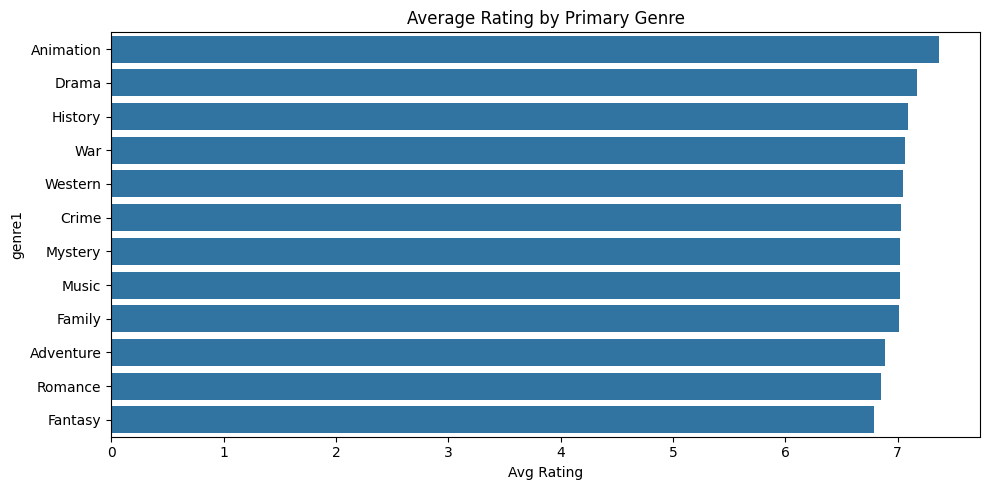

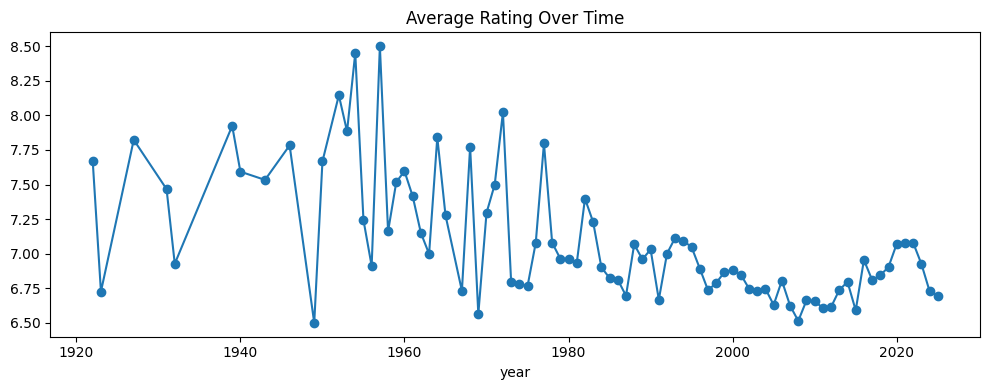

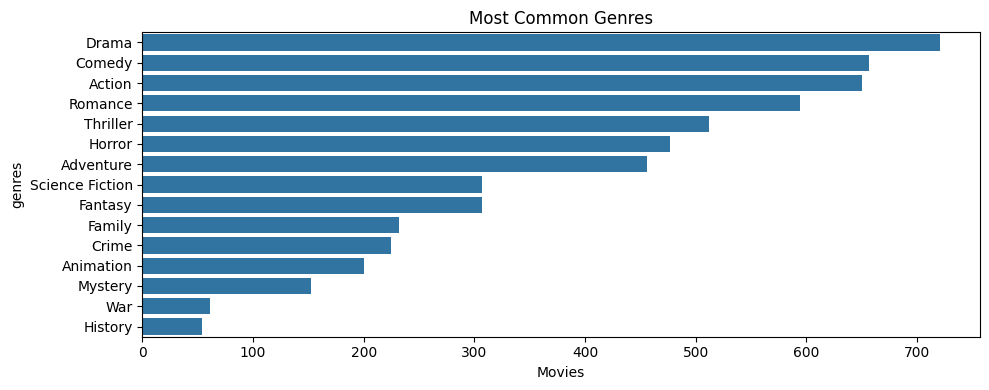

In [108]:
plt.figure(figsize=(10,5))
genre_avg=(df.assign(genre1=df["genres"].str.split(r"\s*\|\s*").str[0])
             .groupby("genre1")["rating"].mean().sort_values(ascending=False).head(12))
sns.barplot(x=genre_avg.values,y=genre_avg.index)
plt.title("Average Rating by Primary Genre"); plt.xlabel("Avg Rating"); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
trend=df.dropna(subset=["year"]).groupby("year")["rating"].mean()
trend.plot(marker="o"); plt.title("Average Rating Over Time"); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
top_genres=(df["genres"].str.split(r"\s*\|\s*").explode().value_counts().head(15))
sns.barplot(x=top_genres.values,y=top_genres.index)
plt.title("Most Common Genres"); plt.xlabel("Movies"); plt.tight_layout(); plt.show()


In [109]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")
text_series = (df["overview"].astype(str)+" "+df["genres"].astype(str))
tfidf = TfidfVectorizer(stop_words=STOPWORDS,max_features=5000,ngram_range=(1,2))
X_text = tfidf.fit_transform(text_series)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [110]:
# ---------------------- Improved Classification ----------------------
from xgboost import XGBClassifier

# Use richer text features: overview + title + genres
text_series = (df["overview"].astype(str) + " " + df["title"].astype(str) + " " + df["genres"].astype(str))
tfidf = TfidfVectorizer(stop_words=STOPWORDS, max_features=8000, ngram_range=(1,2))
X_text = tfidf.fit_transform(text_series)

# Define target
threshold = df["rating"].median()
df["high_rated"] = (df["rating"] >= threshold).astype(int)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_text, df["high_rated"], test_size=0.2, random_state=42, stratify=df["high_rated"])

# Train stronger classifier
clf = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("\n🤖 Improved Classification (High vs Low):")
print(classification_report(y_test, y_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))



🤖 Improved Classification (High vs Low):
              precision    recall  f1-score   support

           0      0.617     0.660     0.638       200
           1      0.634     0.590     0.611       200

    accuracy                          0.625       400
   macro avg      0.626     0.625     0.625       400
weighted avg      0.626     0.625     0.625       400

Confusion matrix:
 [[132  68]
 [ 82 118]]


In [111]:
# ---------------------- Enhanced Regression ----------------------
from sklearn.preprocessing import PolynomialFeatures

# Additional engineered features
df["overview_len"] = df["overview"].apply(lambda x: len(str(x).split()))
df["genre_count"] = df["genres"].apply(lambda x: len(str(x).split("|")) if isinstance(x,str) else 0)
df["is_recent"] = (df["year"] >= 2015).astype(int)
df["year2"] = df["year"] ** 2  # nonlinear relationship
df["log_votes"] = np.log1p(df.get("vote_count", pd.Series(np.ones(len(df)))))  # handles missing column gracefully

# One-hot encode top genres
top_genres = ["Drama","Comedy","Action","Horror","Romance"]
for g in top_genres:
    df[f"genre_{g}"] = df["genres"].str.contains(g, case=False, na=False).astype(int)

X_num = df[["overview_len","genre_count","year","year2","is_recent","log_votes"] + [f"genre_{g}" for g in top_genres]].fillna(0).values
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

# Combine text + numeric
X_all = hstack([X_text, X_num_scaled])

# Split
Xtr_r, Xte_r, ytr_r, yte_r = train_test_split(X_all, df["rating"], test_size=0.2, random_state=42)

# Tuned XGBoost
reg = XGBRegressor(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=8,
    subsample=0.85,
    colsample_bytree=0.9,
    reg_lambda=1.2,
    random_state=42
)
reg.fit(Xtr_r, ytr_r)
pred_r = reg.predict(Xte_r)

print("\n📉 Tuned Regression (rating):")
print(f"  R²  = {r2_score(yte_r, pred_r):.3f}")
print(f"  MAE = {mean_absolute_error(yte_r, pred_r):.3f}")



📉 Tuned Regression (rating):
  R²  = 0.502
  MAE = 0.409


In [112]:
k=6
kmeans=KMeans(n_clusters=k,random_state=42,n_init=10)
df["cluster"]=kmeans.fit_predict(X_text)
print("\n🌀 Cluster rating means:")
print(df.groupby("cluster")["rating"].mean().round(2))

terms=np.array(tfidf.get_feature_names_out())
centers=kmeans.cluster_centers_
print("\n🔠 Top terms per cluster:")
for ci in range(k):
    idx=centers[ci].argsort()[-10:][::-1]
    print(f"  Cluster {ci}: {', '.join(terms[idx])}")



🌀 Cluster rating means:
cluster
0    7.26
1    6.86
2    7.03
3    6.44
4    6.83
5    6.89
Name: rating, dtype: float64

🔠 Top terms per cluster:
  Cluster 0: war, world war, drama, history, war ii, action, world, ii, soldiers, romance
  Cluster 1: science fiction, science, fiction, action, adventure, action science, world, action adventure, adventure science, earth
  Cluster 2: crime, action, thriller, drama, action crime, action thriller, comedy crime, crime thriller, drama thriller, comedy
  Cluster 3: horror, horror thriller, thriller, mystery, horror mystery, night, group, young, one, house
  Cluster 4: romance, drama, drama romance, love, comedy, comedy romance, life, romance drama, woman, comedy drama
  Cluster 5: family, adventure, fantasy, animation, comedy, comedy family, action, new, world, family comedy


In [113]:
def jaccard_genres(a,b):
    sa=set([x.strip() for x in str(a).split("|") if x.strip()])
    sb=set([x.strip() for x in str(b).split("|") if x.strip()])
    if not sa and not sb: return 0.0
    inter=len(sa&sb); union=len(sa|sb)
    return inter/union if union else 0.0

def fetch_and_hist(url):
    if not url or url=="N/A": return np.zeros(96,dtype=np.float32)
    try:
        resp=requests.get(url,timeout=10)
        if resp.status_code!=200: return np.zeros(96,dtype=np.float32)
        img=cv2.imdecode(np.frombuffer(resp.content,np.uint8),cv2.IMREAD_COLOR)
        if img is None: return np.zeros(96,dtype=np.float32)
        img=cv2.resize(img,(128,192))
        hsv=cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
        vec=np.concatenate([
            cv2.calcHist([hsv],[0],None,[32],[0,180]).flatten(),
            cv2.calcHist([hsv],[1],None,[32],[0,256]).flatten(),
            cv2.calcHist([hsv],[2],None,[32],[0,256]).flatten()
        ]).astype(np.float32)
        return vec/ (np.linalg.norm(vec)+1e-9)
    except Exception: return np.zeros(96,dtype=np.float32)

TEXT_SIM=cosine_similarity(X_text)

def recommend(title,n=8,alpha=0.7,beta=0.2,gamma=0.1,poster_k=200):
    hits=df[df["title"].str.lower()==title.lower()]
    if hits.empty:
        alt=df[df["title"].str.lower().str.contains(title.lower())].head(10)["title"].tolist()
        print(f"⚠️ Not found. Try one of: {alt}"); return
    idx=hits.index[0]
    text_sim=TEXT_SIM[idx]; candidates=np.argsort(-text_sim)[1:poster_k+1]
    q_post=fetch_and_hist(df.at[idx,"poster_url"])
    cand_post=np.stack([fetch_and_hist(df.iloc[j]["poster_url"]) for j in candidates])
    post_sim=(cand_post@q_post)
    qg=df.at[idx,"genres"]
    genre_sim=np.array([jaccard_genres(qg,df.iloc[j]["genres"]) for j in candidates])
    hybrid=alpha*text_sim[candidates]+beta*genre_sim+gamma*post_sim
    order=np.argsort(-hybrid)[:n]; rec_idx=candidates[order]
    out=df.iloc[rec_idx][["title","genres","rating","year"]].copy()
    out["score"]=hybrid[order]
    print(f"\n🎬 Because you liked **{df.at[idx,'title']}**:")
    print(out.to_string(index=False))
    return out


In [114]:
try:
    user_title=input("\nType a movie you liked: ").strip()
    if user_title: _=recommend(user_title)
    else:
        s=df.sample(1).iloc[0]["title"]; print(f"(No input) trying: {s}"); _=recommend(s)
except EOFError:
    s=df.sample(1).iloc[0]["title"]; print(f"(No stdin) trying: {s}"); _=recommend(s)

print("\n✅ Step-4 EDA + ML + Hybrid Recommendation finished (with improved regression).")



Type a movie you liked: The Dark Knight

🎬 Because you liked **The Dark Knight**:
                title                            genres  rating  year    score
The Dark Knight Rises Action | Crime | Drama | Thriller   7.788  2012 0.503650
       Batman Forever          Action | Crime | Fantasy   5.400  1995 0.351921
        Batman Begins            Drama | Crime | Action   7.718  2005 0.295482
                Joker          Crime | Thriller | Drama   8.132  2019 0.294705
  Joker: Folie à Deux          Drama | Crime | Thriller   5.410  2024 0.271495
  Law Abiding Citizen          Drama | Crime | Thriller   7.400  2009 0.265378
          Shot Caller          Crime | Drama | Thriller   6.958  2017 0.265109
               Batman          Fantasy | Action | Crime   7.235  1989 0.262330

✅ Step-4 EDA + ML + Hybrid Recommendation finished (with improved regression).
